In [355]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
import chart_studio
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objects as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from chart_studio.plotly import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from keras import backend as K

In [356]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100




In [357]:
def _clean_text(self, text):
    """
        text: a string
        
        return: modified initial string
    """
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '') 
    # text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall

class Lstm_issue():

    def __init__(self, data_location, data_location_ori = 'data/hadoop/HADOOP.csv', aug_mul = 2):
        self.data_ori = pd.read_csv(data_location_ori) # 원본 데이터
        self.aug_mul = aug_mul
        self.df = pd.read_csv(data_location, encoding='cp949')
        print(self.df.info())

        print(self.df.component.value_counts())

        
        self.data_ori['text'] = list(self.data_ori.title + " " + self.data_ori.description)

        '''# fs, build, security, test, documentation, ipc, io, conf, util, scripts, fs/s3, metrics, native, contrib/hod, yetus, tools, record, ha, net, kms, bin
        self.df.loc[self.df['component'] == 'fs/swift,test', 'component'] = 'test'
        #self.df = self.df[self.df.component != 'Other financial service']'''

        for x in range(len(self.df.component)):
            self.df.component[x] = self.df.component[x].split(',')[0]

        self.Y = pd.get_dummies(self.df[set(self.df.component)])
        print(self.df.component.value_counts())

    def print_plot(self, index):
        example = self.df[self.df.index == index][['text', 'component']].values[0]
        if len(example) > 0:
            print(example[0])
            print('component:', example[1])

    def preprocessing(self):
        self.df = self.df.reset_index(drop=True)
        self.df = self.df.astype(str)
    
    def clean_text(self):
        '''self.df['text'] = self.df['text'].apply(_clean_text)
        self.df['text'] = self.df['text'].str.replace('\d+', '')'''
        refined_data = []
        for item in self.df['text']:
            #1. Remove \r 
            current_desc = item.replace('\r', ' ')    
            #2. Remove URLs
            current_desc = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', current_desc)    
            #4. Remove hex code
            current_desc = re.sub(r'(\w+)0x\w+', '', current_desc) 
            #5. Change to lower case
            current_desc = current_desc.lower()   
            #6. Tokenize
            #current_desc_tokens = tokenizer(current_desc, add_special_tokens= True)
            #7. Strip trailing punctuation marks    
            #current_desc_filter = [word.strip(string.punctuation) for word in current_desc_tokens]     
            #8. Join the lists
            #current_data = current_desc_filter
            #current_data = list(filter(None, current_data))
            refined_data.append(current_desc)
        self.df['text'] = refined_data
        self.df['text'] = self.df['text'].str.replace('\d+', '')
    
    def tokenize_df(self):
        '''# The maximum number of words to be used. (most frequent)
        MAX_NB_WORDS = 50000
        # Max number of words in each complaint.
        MAX_SEQUENCE_LENGTH = 250
        # This is fixed.
        EMBEDDING_DIM = 100'''
        self.tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
        self.tokenizer.fit_on_texts(self.df['text'].values)
        word_index = self.tokenizer.word_index
        print('Found %s unique tokens.' % len(word_index))

    # 불러온 정제된 데이터 one hot을 str에서 list로 바꾸는 작업
    def labels_to_int(self):
        x, y = train_test_split(self.data_ori, test_size = 0.2, random_state=42)
        self.X_ori = x.text
        self.Y_ori = y.component

        #self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X_ori, self.Y_ori, test_size = 0.20, random_state = 21)

        # 증강데이터의 train_data에서 test index부분 제거
        y_index = list(y.index)
        #test_index_list = list(self.test_data.index)
        test_index =[]
        for aug_num in range(self.aug_mul):
            iidf2 = [i + 6152* aug_num for i in y_index]
            test_index = test_index + iidf2

        # labeling y
        #self.Y = pd.get_dummies(self.df['component'])
        df_compset = list(set(self.df.component.values))
        #self.Y = pd.get_dummies(self.df[set(self.df.component)])
        #self.Y = pd.get_dummies(self.df['fs'])
        
        self.X_train = self.df['text'].drop(test_index)
        self.X_train = self.X_train.sample(frac=1).reset_index(drop=True)
        X_train_index = list(self.X_train.index)
        self.X_test = self.df['text'].drop(X_train_index)
        self.X_test = self.X_test.sample(frac=1).reset_index(drop=True)

        self.Y_train = self.Y.drop(test_index)
        self.Y_train = self.Y_train.sample(frac=1).reset_index(drop=True)
        self.Y_test = self.Y.drop(X_train_index)
        self.Y_test = self.Y_test.sample(frac=1).reset_index(drop=True)
        # tokenize x, y
        self.X_train = self.tokenizer.texts_to_sequences(self.X_train.values)
        #self.X = self.tokenizer.texts_to_sequences(df_text_ori)
        self.X_train = pad_sequences(self.X_train, maxlen=MAX_SEQUENCE_LENGTH)

        self.X_test = self.tokenizer.texts_to_sequences(self.X_test.values)
        #self.X = self.tokenizer.texts_to_sequences(df_text_ori)
        self.X_test = pad_sequences(self.X_test, maxlen=MAX_SEQUENCE_LENGTH)
        print('X Shape of data tensor:', self.X_train.shape, self.X_test.shape)

        # tokenize x, y ori 
        self.X_ori = self.tokenizer.texts_to_sequences(self.X_ori.values)
        #self.X = self.tokenizer.texts_to_sequences(df_text_ori)
        self.X_ori = pad_sequences(self.X_ori, maxlen=MAX_SEQUENCE_LENGTH)
        print('X_ori Shape of data tensor:', self.X_train.shape, self.X_ori.shape)
        self.Y_ori = pd.get_dummies(self.Y_ori).values
        print('Shape of label tensor:', self.Y_ori.shape)

        '''print('xori, yori: ', self.X_ori.shape, self.Y_ori.shape)
        self.X_train_ori, self.X_test_ori, self.Y_train_ori, self.Y_test_ori = train_test_split(self.X_ori, self.Y_ori, test_size=0.2, random_state=42)'''
        
        '''self.Y_train = pd.get_dummies(self.Y_train).values
        self.Y_test = pd.get_dummies(self.Y_test).values'''
        print('Y Shape of label tensor:', self.Y_train.shape, self.Y_test.shape)

        print('X train Shape of data tensor:', self.X_train.shape,'X test: ', self.X_test.shape)
        print('Y Shape of label tensor:', self.Y_train.shape,'X test: ', self.Y_test.shape)
        
     
    def set_model(self):
        self.model = Sequential()
        self.model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=self.X_train.shape[1]))
        self.model.add(SpatialDropout1D(0.2))
        self.model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
        self.model.add(Dense(37, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall(top_k = 15), 'accuracy'])
    
    def run_model(self):
        epochs = 5
        batch_size = 64

        self.history = self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    def run_model_ori(self):
        epochs = 5
        batch_size = 64

        self.history = self.model.fit(self.X_train_ori, self.Y_train_ori, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    
    def test_model(self):
        self.accr = self.model.evaluate(self.X_test, self.Y_test)
        print('Test set\n Loss: {:0.3f}\n Accuracy: {0.3f}'.format(self.accr[0], self.accr[1]))

    def test_model_ori(self):
        self.accr = self.model.evaluate(self.X_test_ori, self.Y_test_ori)
        print('Test set\n Loss: {:0.3f}\n Accuracy: {0.3f}'.format(self.accr[0], self.accr[1]))


In [358]:
dataloc1 = "data/hadoop/HADOOP_char_Keyboard_ori.csv"
dataloc2 = "data/hadoop/HADOOP_char_OCR_ori.csv"
dataloc3 = "data/hadoop/HADOOP_word_Antonym_ori.csv"
dataloc4 = "data/hadoop/HADOOP_word_ContextualWordEmbs_ori.csv"
dataloc4 = "data/hadoop/HADOOP_word_Spelling_ori.csv"
dataloc5 = "data/hadoop/HADOOP_word_Split_ori.csv"
dataloc6 = "data/hadoop/HADOOP_word_Synonym_ori.csv"
dataloc7 = "data/hadoop/HADOOP_word_TfidfAug_ori.csv"
pius_word1 = Lstm_issue(dataloc7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43064 entries, 0 to 43063
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text                    43064 non-null  object
 1   labels                  43064 non-null  object
 2   component               43064 non-null  object
 3   auto-failover           43064 non-null  int64 
 4   azure                   43064 non-null  int64 
 5   benchmarks              43064 non-null  int64 
 6   bin                     43064 non-null  int64 
 7   build                   43064 non-null  int64 
 8   conf                    43064 non-null  int64 
 9   contrib/cloud           43064 non-null  int64 
 10  contrib/eclipse-plugin  43064 non-null  int64 
 11  contrib/hod             43064 non-null  int64 
 12  contrib/serialization   43064 non-null  int64 
 13  documentation           43064 non-null  int64 
 14  filecache               43064 non-null  int64 
 15  fs

In [359]:
#pius_word1.print_plot(2)
pius_word1.preprocessing()
pius_word1.clean_text()
pius_word1.tokenize_df()
pius_word1.labels_to_int()

D:\Users\PiusHwang\anaconda3\lib\site-packages\ipykernel_launcher.py:92: FutureWarning:

The default value of regex will change from True to False in a future version.



Found 49852 unique tokens.
X Shape of data tensor: (40602, 250) (2462, 250)
X_ori Shape of data tensor: (40602, 250) (4921, 250)
Shape of label tensor: (1231, 92)
Y Shape of label tensor: (40602, 37) (2462, 37)
X train Shape of data tensor: (40602, 250) X test:  (2462, 250)
Y Shape of label tensor: (40602, 37) X test:  (2462, 37)


In [360]:
xx = pd.get_dummies(pius_word1.df[list(pius_word1.df.columns.drop(labels=['text', 'labels', 'component']))])

In [361]:
xx.columns

Index(['auto-failover_0', 'auto-failover_1', 'azure_0', 'azure_1',
       'benchmarks_0', 'benchmarks_1', 'bin_0', 'bin_1', 'build_0', 'build_1',
       'conf_0', 'conf_1', 'contrib/cloud_0', 'contrib/cloud_1',
       'contrib/eclipse-plugin_0', 'contrib/eclipse-plugin_1', 'contrib/hod_0',
       'contrib/hod_1', 'contrib/serialization_0', 'contrib/serialization_1',
       'documentation_0', 'documentation_1', 'filecache_0', 'filecache_1',
       'fs_0', 'fs_1', 'fs/azure_0', 'fs/azure_1', 'fs/s3_0', 'fs/s3_1',
       'fs/swift_0', 'fs/swift_1', 'ha_0', 'ha_1', 'io_0', 'io_1', 'ipc_0',
       'ipc_1', 'kms_0', 'kms_1', 'metrics_0', 'metrics_1', 'native_0',
       'native_1', 'net_0', 'net_1', 'nfs_0', 'nfs_1', 'performance_0',
       'performance_1', 'record_0', 'record_1', 'scripts_0', 'scripts_1',
       'security_0', 'security_1', 'site_0', 'site_1', 'test_0', 'test_1',
       'tools_0', 'tools_1', 'tools/distcp_0', 'tools/distcp_1', 'tracing_0',
       'tracing_1', 'trash_0', 'tras

In [362]:
pius_word1.df['fs']

0        1
1        0
2        1
3        0
4        1
        ..
43059    0
43060    0
43061    1
43062    0
43063    0
Name: fs, Length: 43064, dtype: object

In [363]:
pius_word1.X_train.dtype
pius_word1.Y_train

dtype('int32')

,build,conf,contrib/cloud,auto-failover,security,trash,benchmarks,site,documentation,metrics,...,contrib/serialization,bin,ipc,kms,contrib/eclipse-plugin,test,net,filecache,native,yetus
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40597,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40598,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
40599,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40600,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [364]:
pd.get_dummies(pius_word1.Y_train, )

,build,conf,contrib/cloud,auto-failover,security,trash,benchmarks,site,documentation,metrics,...,contrib/serialization,bin,ipc,kms,contrib/eclipse-plugin,test,net,filecache,native,yetus
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40597,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40598,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
40599,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40600,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [365]:
pius_word1.set_model()
pius_word1.run_model()

Epoch 1/5
571/571 [==============================] - 430s 753ms/step - loss: 3.2005 - recall_7: 0.8931 - accuracy: 0.1329 - val_loss: 3.1645 - val_recall_7: 0.9015 - val_accuracy: 0.1305
Epoch 2/5
571/571 [==============================] - 451s 790ms/step - loss: 3.1752 - recall_7: 0.8986 - accuracy: 0.1329 - val_loss: 3.1588 - val_recall_7: 0.8958 - val_accuracy: 0.1305
Epoch 3/5
571/571 [==============================] - 446s 781ms/step - loss: 3.1748 - recall_7: 0.8996 - accuracy: 0.1352 - val_loss: 3.1663 - val_recall_7: 0.9062 - val_accuracy: 0.1305
Epoch 4/5
571/571 [==============================] - 442s 774ms/step - loss: 3.1744 - recall_7: 0.8996 - accuracy: 0.1367 - val_loss: 3.1606 - val_recall_7: 0.9062 - val_accuracy: 0.1305
Epoch 5/5
571/571 [==============================] - 439s 769ms/step - loss: 3.1732 - recall_7: 0.8983 - accuracy: 0.1347 - val_loss: 3.1636 - val_recall_7: 0.9062 - val_accuracy: 0.1305


In [366]:
accr = pius_word1.model.evaluate(pius_word1.X_test, pius_word1.Y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

77/77 [==============================] - 4s 50ms/step - loss: 3.3650 - recall_7: 0.8564 - accuracy: 0.1028
Test set
 Loss: 3.365
 Accuracy: 0.856


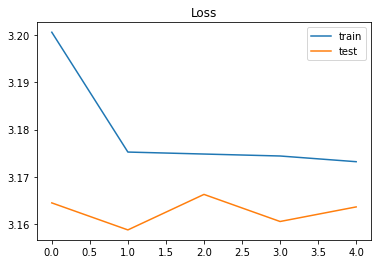

In [367]:
plt.title('Loss')
plt.plot(pius_word1.history.history['loss'], label='train')
plt.plot(pius_word1.history.history['val_loss'], label='test')
plt.legend()
plt.show();

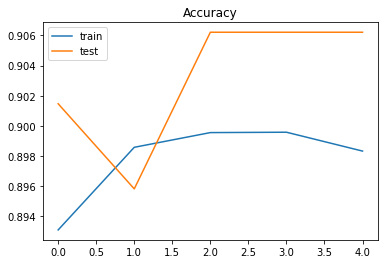

In [369]:
plt.title('Accuracy')
plt.plot(pius_word1.history.history['recall_7'], label='train')
plt.plot(pius_word1.history.history['val_recall_7'], label='test')
plt.legend()
plt.show();

In [ ]:
from keras.utils import plot_model
plot_model(pius_word1.model, show_shapes = True, show_layer_names = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
'''pius_word1.df['component'].value_counts().sort_values(ascending=False).iplot(kind = 'bar', yTitle = 'Number of Complaints', title = 'Number complaints in each component')'''

In [ ]:
'''def set_model():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(37, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])'''
